In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ar-data/ar_source.mov
/kaggle/input/ar-data/cv_cover.jpg
/kaggle/input/ar-data/book.mov


# **AR overlay for first frames**

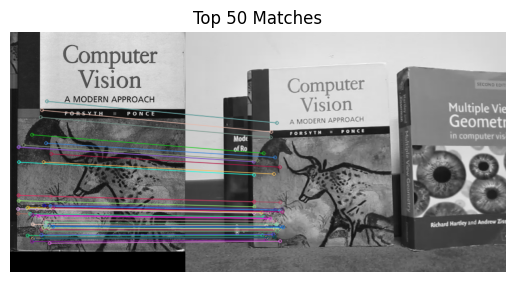

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

book_img = cv2.imread("/kaggle/input/ar-data/cv_cover.jpg", cv2.IMREAD_GRAYSCALE)
book_vid = cv2.VideoCapture("/kaggle/input/ar-data/book.mov")
ret, first_frame = book_vid.read()
first_frame_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(book_img, None)
kp2, des2 = sift.detectAndCompute(first_frame_gray, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
good = [m[0] for m in matches if len(m) == 2 and m[0].distance < 0.75 * m[1].distance]

img_matches = cv2.drawMatches(book_img, kp1, first_frame_gray, kp2, good[:50], None, flags=2)
plt.imshow(img_matches), plt.title("Top 50 Matches"), plt.axis('off')
plt.show()


In [ ]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in good[:50]]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good[:50]]).reshape(-1,1,2)

H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

book_img_color = cv2.cvtColor(book_img, cv2.COLOR_GRAY2BGR)
for pt in src_pts:
    x, y = pt[0]
    cv2.circle(book_img_color, (int(x), int(y)), 3, (0,255,0), -1)


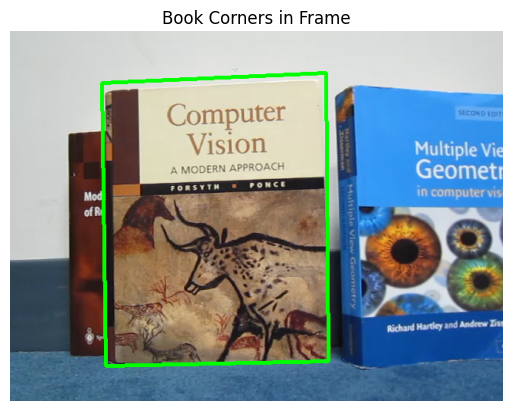

In [ ]:
h, w = book_img.shape
corners = np.float32([[0,0], [w,0], [w,h], [0,h]]).reshape(-1,1,2)
book_corners_in_frame = cv2.perspectiveTransform(corners, H)

frame_with_box = first_frame.copy()
cv2.polylines(frame_with_box, [np.int32(book_corners_in_frame)], True, (0,255,0), 3)
plt.imshow(cv2.cvtColor(frame_with_box, cv2.COLOR_BGR2RGB))
plt.title("Book Corners in Frame")
plt.axis('off')
plt.show()

In [ ]:
ar_vid = cv2.VideoCapture("/kaggle/input/ar-data/ar_source.mov")
ret, ar_frame = ar_vid.read()

book_width = np.linalg.norm(book_corners_in_frame[1] - book_corners_in_frame[0])
book_height = np.linalg.norm(book_corners_in_frame[0] - book_corners_in_frame[3])
aspect_ratio = book_width / book_height

ar_h, ar_w, _ = ar_frame.shape
new_w = int(ar_h * aspect_ratio)
start_x = (ar_w - new_w) // 2
cropped_ar_frame = ar_frame[:, start_x:start_x + new_w]


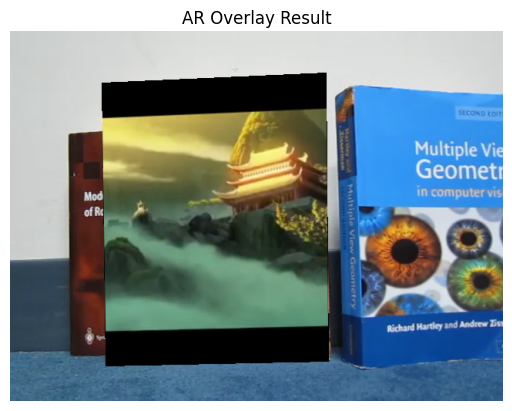

In [6]:
resized_ar = cv2.resize(cropped_ar_frame, (int(book_width), int(book_height)))

dst_corners = book_corners_in_frame
src_corners = np.float32([[0,0], [resized_ar.shape[1],0], [resized_ar.shape[1],resized_ar.shape[0]], [0,resized_ar.shape[0]]])
H_ar_to_book = cv2.getPerspectiveTransform(src_corners, dst_corners)

warped_ar = cv2.warpPerspective(resized_ar, H_ar_to_book, (first_frame.shape[1], first_frame.shape[0]))

mask = np.zeros_like(first_frame, dtype=np.uint8)
cv2.fillConvexPoly(mask, np.int32(dst_corners), (255,255,255))
masked_frame = cv2.bitwise_and(first_frame, cv2.bitwise_not(mask))
final = cv2.add(masked_frame, warped_ar)

plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB)), plt.title("AR Overlay Result"), plt.axis('off')
plt.show()


**We are now done overlaying the first fram of the AR video clip on the detected book's position in the image drawn from the first frame of the book clip.**

**Now, we need to carry out the same procedure for all frames of the book clip and the AR source movie**

# **Full AR Movie**

In [15]:
import cv2
import numpy as np

book_img = cv2.imread("/kaggle/input/ar-data/cv_cover.jpg", cv2.IMREAD_GRAYSCALE)
h_book, w_book = book_img.shape

sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

kp_book, des_book = sift.detectAndCompute(book_img, None)

book_vid = cv2.VideoCapture("/kaggle/input/ar-data/book.mov")
ar_vid = cv2.VideoCapture("/kaggle/input/ar-data/ar_source.mov")

fps = int(book_vid.get(cv2.CAP_PROP_FPS))
width = int(book_vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(book_vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter("output_ar_video.avi", fourcc, fps, (width, height))

frame_index = 0
while True:
    ret_book, frame_book = book_vid.read()
    ret_ar, frame_ar = ar_vid.read()

    if not ret_book or not ret_ar:
        break

    frame_gray = cv2.cvtColor(frame_book, cv2.COLOR_BGR2GRAY)
    kp_frame, des_frame = sift.detectAndCompute(frame_gray, None)

    matches = bf.knnMatch(des_book, des_frame, k=2)
    good = [m[0] for m in matches if len(m) == 2 and m[0].distance < 0.75 * m[1].distance]

    src_pts = np.float32([kp_book[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

    book_corners = np.float32([[0, 0], [w_book, 0], [w_book, h_book], [0, h_book]]).reshape(-1, 1, 2)
    mapped_corners = cv2.perspectiveTransform(book_corners, H)

    ar_h, ar_w, _ = frame_ar.shape
    book_w = np.linalg.norm(mapped_corners[1] - mapped_corners[0])
    book_h = np.linalg.norm(mapped_corners[0] - mapped_corners[3])
    aspect_ratio = book_w / book_h

    new_crop_w = int(ar_h * aspect_ratio)

    start_x = (ar_w - new_crop_w) // 2
    cropped_ar = frame_ar[:, start_x:start_x + new_crop_w]
    resized_ar = cv2.resize(cropped_ar, (int(book_w), int(book_h)))

    src_corners = np.float32([[0, 0], [resized_ar.shape[1], 0], [resized_ar.shape[1], resized_ar.shape[0]], [0, resized_ar.shape[0]]])
    H_ar_to_frame = cv2.getPerspectiveTransform(src_corners, mapped_corners)
    warped_ar = cv2.warpPerspective(resized_ar, H_ar_to_frame, (width, height))

    mask = np.zeros_like(frame_book, dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(mapped_corners), (255, 255, 255))
    frame_clean = cv2.bitwise_and(frame_book, cv2.bitwise_not(mask))
    final_frame = cv2.add(frame_clean, warped_ar)

    final_frame = cv2.resize(final_frame, (width, height))
    out.write(final_frame)
    frame_index += 1

book_vid.release()
ar_vid.release()
out.release()
cv2.destroyAllWindows()

✅ AR video created: output_ar_video.avi
